In [ ]:
#hide
#default_exp single_input_pred
from nbdev.showdoc import show_doc

# Single Input Prediction

In [ ]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Code for preprocessing (Logic explained in Notebook 00)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label_tensor = tf.strings.substr(parts[-1], pos=9, len=1)
    return label_tensor

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_spectrogram(waveform):
    diff = [16000] - tf.shape(waveform)
    waveform = tf.cast(waveform, tf.float32)
    
    if diff >= 0:
        zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
        equal_length = tf.concat([waveform, zero_padding], 0)
    else:
        equal_length = tf.slice(waveform, [0], [16000])
        
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == label_strings)
    return spectrogram, label_id

def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

### Set path containing data

In [ ]:
choices = ['digits', 'letters', 'mixed']
dataset_type = choices[0]

if dataset_type == 'digits':
    label_strings = np.array([str(num) for num in range(0,10)])
elif dataset_type == 'letters':
    label_strings = np.array(list(string.ascii_lowercase))
else:
    label_strings = np.array([str(num) for num in range(0,10)] + list(string.ascii_lowercase))

data_dir = pathlib.Path('data/avicar_some'+dataset_type)

### Load model

In [ ]:
model_dir = 'models'
model_name = 'model_single_digit'

In [ ]:
model = keras.models.load_model(os.path.join(model_dir, model_name))

### Predict

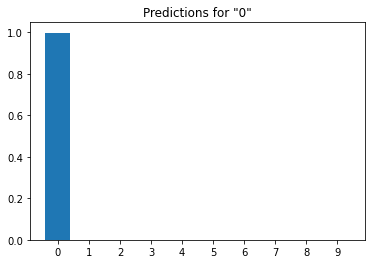

In [ ]:
sample_file = data_dir/'AF1_35D_D0_C1_M3.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(label_strings, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{label_strings[label[0]]}"')
    plt.show()